In [31]:
from concepts import Context as BaseContext
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re

In [32]:
class Context(BaseContext):
    def __init__(self, objetos, atributos, bools, confianza=0.85, soporte=32/712):
        super().__init__(objetos, atributos, bools)
        self.confianza = confianza
        self.soporte = soporte
        self.base_stem = None
        self.base_luxenburger = None
        self.base_completa = None

    @classmethod
    def desde_dataframe(cls, df, confianza=0.85, soporte=32/712):
        # Eliminar la primera columna del dataframe df que corresponde al id
        df = df.iloc[:, 1:]
        objetos = list(df.index.astype(str))
        atributos = list(df.columns.astype(str))
        bools = [tuple(bool(x) for x in fila) for fila in df.values]
        return cls(objetos, atributos, bools, confianza, soporte)


    def set_confianza(self, confianza):
        """Establece el valor del hiperparámetro confianza."""
        self.confianza = confianza

    def get_confianza(self):
        """Obtiene el valor del hiperparámetro confianza."""
        return self.confianza

    def set_soporte(self, soporte):
        """Establece el valor del hiperparámetro soporte."""
        self.soporte = soporte

    def get_soporte(self):
        """Obtiene el valor del hiperparámetro soporte."""
        return self.soporte
    
    def cerrar(self, conj, impls):
        """Cierra un conjunto de atributos usando la base de implicaciones de entrada."""
        cerrado = set(conj)
        cambios = True
        while cambios:
            cambios = False
            for impl,_,_ in impls:
                if impl[0].issubset(cerrado) and not impl[1].issubset(cerrado):
                    cerrado.update(impl[1])
                    cambios = True
        return cerrado

    def next_closure(self, conjunto, conj_impls):
        """Calcula el siguiente cierre de un conjunto de atributos."""
        rev_set_prop=sorted(self.properties, reverse=True)
        for atributo in rev_set_prop:
            if atributo in conjunto:
                conjunto=conjunto - {atributo}
            else:
                sig_conj_cerrado=self.cerrar(conjunto | {atributo}, conj_impls)
                if all(x >= atributo for x in sig_conj_cerrado - conjunto):
                    return sig_conj_cerrado
        return None
    
    def doble_derivada(self, conjunto):
        """Calcula la doble derivada de un conjunto de atributos."""
        conjunto2 = set(conjunto)
        return set(self.intension(self.extension(conjunto2)))

    def calcular_base_stem(self):
        """Calcula la base Stem de un contexto como lista de tuplas."""
        conj_atrib=set()
        base=[]
        atributos=set(self.properties)
        while conj_atrib!=atributos and conj_atrib!= None:
            conj_atrib_pp=self.doble_derivada(conj_atrib)
            if conj_atrib != conj_atrib_pp:
                implicacion = (conj_atrib, conj_atrib_pp - conj_atrib)
                base.append((implicacion, 1., self.soporte_implicacion(implicacion)))
            conj_atrib = self.next_closure(conj_atrib, base)
        self.base_stem = base
        return base

    def es_cerrado(self, conjunto):
        """Determina si un conjunto de atributos es cerrado en un contexto formal."""
        return conjunto == set(self.intension(self.extension(conjunto)))

    def soporte_atributos(self, conjunto):
        """Calcula el soporte de un conjunto de atributos en un contexto formal."""
        numerador = len(self.extension(conjunto))  # |A'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def soporte_concepto(self, concepto):
        """Calcula el soporte de un concepto en un contexto formal."""
        extension, _ = concepto
        numerador = len(extension)
        denominador = len(self.objects)
        return numerador / denominador

    def sigma_frecuente(self, concepto, sigma):
        """Determina si un concepto es frecuente en un contexto formal."""
        return self.soporte_concepto(concepto) >= sigma

    def es_inmediatamente_inferior(self, Y1, Y2):
        """Determina, por medio de sus conjuntos de atributos, si un concepto es inmediatamente inferior a otro en un contexto formal."""
        if Y1 == Y2:  # Si los conjuntos de atributos son iguales, no son inmediatamente inferiores
            return False
        if not Y1.issubset(Y2):  # Si Y1 no es subconjunto de Y2, no son inmediatamente inferiores
            return False
        if not self.es_cerrado(Y1) or not self.es_cerrado(Y2):  # Si alguno de los conjuntos de atributos no es cerrado, no son inmediatamente inferiores
            return False
        extension1 = self.extension(Y1)
        extension2 = self.extension(Y2)
        vecinos = [(set(extension), set(intension)) for extension, intension in self.neighbors(extension2)]
        conceptoY1 = (set(extension1), Y1)
        if conceptoY1 in vecinos:  # Si el concepto (A', Y1) está en los vecinos de (A'', Y2), entonces Y1 es inmediatamente inferior a Y2
            return True
        else:
            return False

    def soporte_implicacion(self, implicacion):
        """Calcula el soporte de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def confianza_implicacion(self, implicacion):
        """Calcula la confianza de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.extension(antecedente))  # |Y1'|
        if denominador == 0:
            return 1.0
        return numerador / denominador

    def calcular_base_luxenburger(self):
        """Calcula la base de Luxenburger de un contexto formal como lista de tuplas de conjuntos de atributos."""
        base_luxenburger = []
        visitados = set()
        reticulo = self.lattice
        n = len(self.objects)
        def aux_base_luxenburger(concepto_actual):
            """Auxiliar para recorrer cada nodo del reticulo del contexto formal de arriba a abajo."""
            if concepto_actual in visitados: # Si el concepto actual ya fue visitado, no hacer nada
                return
            visitados.add(concepto_actual)
            for vecino in concepto_actual.lower_neighbors: # Recorrer los vecinos inferiores del concepto actual
                intencion_vecino = set(vecino.intent)
                intencion_actual = set(concepto_actual.intent)
                implicacion = (intencion_actual, intencion_vecino - intencion_actual) # Representa la implicacion Act -> Vec\Act
                num_objetos_actual = len(concepto_actual.extent)
                if num_objetos_actual != 0:
                    conf_Implicacion = len(vecino.extent)/num_objetos_actual
                else:
                    conf_Implicacion = 0.
                sop_Implicacion = len(vecino.extent)/n
                if sop_Implicacion >= self.soporte and conf_Implicacion >= self.confianza: # Si la implicacion es frecuente, agregarla a la base de Luxenburger
                    base_luxenburger.append((implicacion, conf_Implicacion, sop_Implicacion))
                elif sop_Implicacion < self.soporte: # Realizar la poda si el soporte es menor al umbral
                    return
                aux_base_luxenburger(vecino)
        aux_base_luxenburger(reticulo[len(reticulo)-1]) # Comenzar desde el concepto superior del reticulo
        self.base_luxenburger = base_luxenburger
        return base_luxenburger
    
    def calcular_base_completa(self):
        """Calcula la base completa como la union de la base Stem y de Luxenburger."""
        if self.base_stem is None:
            raise Exception("Primero debe calcular la base Stem.")
        if self.base_luxenburger is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")

        base_completa = self.base_stem.copy()
        base_completa.extend(self.base_luxenburger)
        self.base_completa = base_completa
        return base_completa
    
    def cerrar_conjunto(self, conjunto):
        """Dado un conjunto de atributos y la base de implicaciones, devuelve el conjunto cerrado."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        cerrado = set(conjunto)
        cambios = True
        while cambios:
            cambios = False
            for implicacion,_,_ in self.base_completa:
                if implicacion[0].issubset(cerrado) and not implicacion[1].issubset(cerrado):
                    cerrado.update(implicacion[1])
                    cambios = True
        return cerrado
    
    def entrenar(self):
        """Calcula todas las bases de un contexto formal."""
        self.calcular_base_stem()
        self.calcular_base_luxenburger()
        self.calcular_base_completa()
    
    def predecir(self, datos):
        """Predice las etiquetas de un dataframe de Xs y vacios aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        etiquetas = []
        datos.drop(columns=["Exited"], inplace=True, errors='ignore')
        for i in range(len(datos)):
            instancia = datos.iloc[i]
            conjunto = set(datos.columns[1:][instancia.iloc[1:] == "X"])
            cerrado = self.cerrar_conjunto(conjunto)
            if "Exited" in cerrado:
                etiquetas.append("X")
            else:
                etiquetas.append("")
        return pd.Series(etiquetas, index=datos.index, name="Exited")
    
    def precision(self, datos, etiquetas):
        """Calcula la precisión de un dataframe de Xs y vacios con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        return coincidencias.mean()
    
    def falsos_positivos(self, datos, etiquetas):
        """Calcula la cantidad de falsos positivos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_positivos = ((predicciones == "X") & (etiquetas == "")).sum()
        return falsos_positivos
    
    def falsos_negativos(self, datos, etiquetas):
        """Calcula la cantidad de falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_negativos = ((predicciones == "") & (etiquetas == "X")).sum()
        return falsos_negativos
    
    def calcula_resultados(self, datos, etiquetas):
        """Calcula la precisión, falsos positivos y falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        falsos_positivos = ((predicciones == "X") & (etiquetas == "")).sum()
        falsos_negativos = ((predicciones == "") & (etiquetas == "X")).sum()
        return coincidencias.mean(), falsos_positivos, falsos_negativos

In [33]:
#Cargar el dataset de Churn Modelling
data = pd.read_csv("churn_Modelling.csv")
print(data.head())

#Este conjunto de datos contiene información sobre los clientes de un banco, 
#y la variable objetivo es una variable binaria que indica si el cliente dejó el banco (cerró su cuenta) o si sigue siendo cliente.

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
Valores únicos de Geography: ['France' 'Spain' 'Germany']
Valores únicos de Age: [42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49
 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53
 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Valores únicos de Tenure: [ 2  1  8  7  4  6  3 10  5  9  0]
Valores únicos de NumOfProducts: [1 3 2 4]


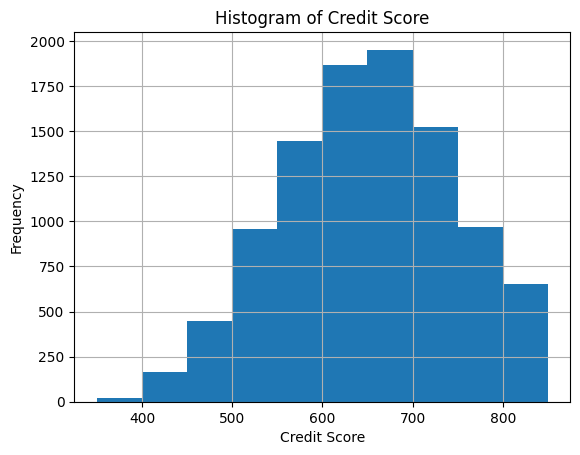

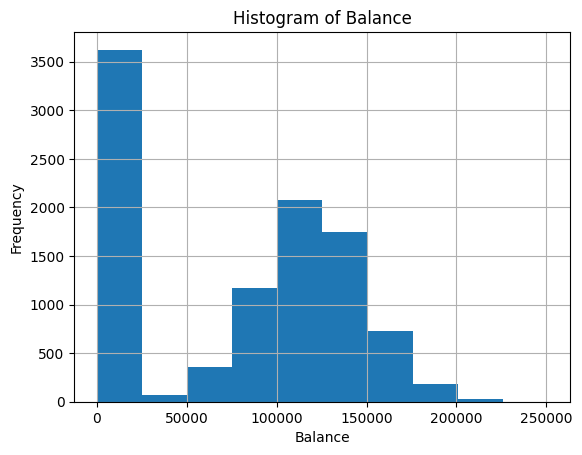

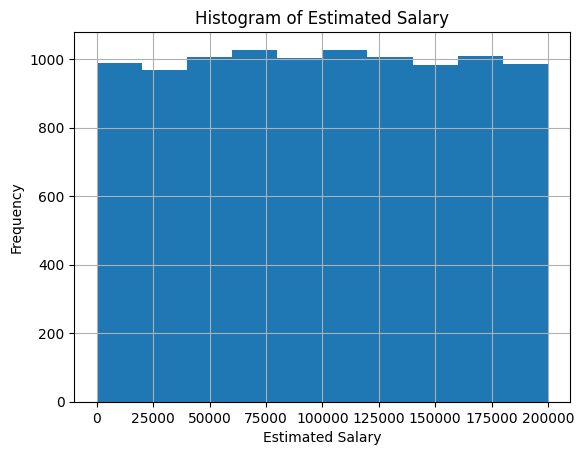

In [34]:
print(data.columns)

# Mostrar los valores únicos de las columnas
print("Valores únicos de Geography:", data['Geography'].unique())
print("Valores únicos de Age:", data['Age'].unique())
print("Valores únicos de Tenure:", data['Tenure'].unique())
print("Valores únicos de NumOfProducts:", data['NumOfProducts'].unique())


# Crear un histograma con 10 intervalos
data['CreditScore'].hist(bins=10)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Histogram of Credit Score')
plt.show()

# Crear un histograma con 10 intervalos
data['Balance'].hist(bins=10)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance')
plt.show()

# Crear un histograma con 10 intervalos
data['EstimatedSalary'].hist(bins=10)
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated Salary')
plt.show()

In [35]:
# Calcular los máximos y mínimos de cada columna
maximos = data.max()
minimos = data.min()
print("Máximos de cada columna:")
print(maximos)
print("\nMínimos de cada columna:")
print(minimos)

Máximos de cada columna:
RowNumber              10000
CustomerId          15815690
Surname               Zuyeva
CreditScore              850
Geography              Spain
Gender                  Male
Age                       92
Tenure                    10
Balance            250898.09
NumOfProducts              4
HasCrCard                  1
IsActiveMember             1
EstimatedSalary    199992.48
Exited                     1
dtype: object

Mínimos de cada columna:
RowNumber                 1
CustomerId         15565701
Surname               Abazu
CreditScore             350
Geography            France
Gender               Female
Age                      18
Tenure                    0
Balance                 0.0
NumOfProducts             1
HasCrCard                 0
IsActiveMember            0
EstimatedSalary       11.58
Exited                    0
dtype: object


In [36]:
#'RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
#'IsActiveMember', 'EstimatedSalary', 'Exited'

# Reemplazar valores nulos
data.loc[:, 'CreditScore'] = data['CreditScore'].fillna(data['CreditScore'].mean())
data.loc[:, 'Geography'] = data['Geography'].fillna(data['Geography'].mode()[0])
data.loc[:, 'Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data.loc[:, 'Age'] = data['Age'].fillna(data['Age'].mode()[0])
data.loc[:, 'Tenure'] = data['Tenure'].fillna(int(data['Tenure'].mean()))
data.loc[:, 'Balance'] = data['Balance'].fillna(data['Balance'].mean())
data.loc[:, 'NumOfProducts'] = data['NumOfProducts'].fillna(data['NumOfProducts'].mode()[0])
data.loc[:, 'HasCrCard'] = data['HasCrCard'].fillna(data['HasCrCard'].mode()[0])
data.loc[:, 'IsActiveMember'] = data['IsActiveMember'].fillna(data['IsActiveMember'].mode()[0])
data.loc[:, 'EstimatedSalary'] = data['EstimatedSalary'].fillna(data['EstimatedSalary'].mean())
data.loc[:, 'Exited'] = data['Exited'].fillna(data['Exited'].mode()[0])


# Definir intervalos y etiquetas de credit score
credit_score_bins = [300, 600, 900]
credit_score_labels = ["300-600", "600-900"]
# Crear una nueva columna con categorías de credit score
data["CreditScoreGroup"] = pd.cut(data["CreditScore"], bins=credit_score_bins, labels=credit_score_labels, right=False)

# Definir intervalos y etiquetas de edad
age_bins = [0, 18, 35, 55, 100]
age_labels = ["0-18", "18-35", "35-55", "55-100"]
# Crear una nueva columna con categorías de edad
data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels, right=False)

# Definir intervalos y etiquetas de tenure
tenure_bins = [0, 1, 5, 10]
tenure_labels = ["0-1", "1-5", "5-10"]
# Crear una nueva columna con categorías de tenure
data["TenureGroup"] = pd.cut(data["Tenure"], bins=tenure_bins, labels=tenure_labels, right=False)

# Definir intervalos y etiquetas de balance
balance_bins = [0, 50000, 150000, 300000]
balance_labels = ["0-50000", "50000-150000", "150000-300000"]
# Crear una nueva columna con categorías de balance
data["BalanceGroup"] = pd.cut(data["Balance"], bins=balance_bins, labels=balance_labels, right=False)

# Definir intervalos y etiquetas de Estimated Salary
estimated_salary_bins = [0, 50000, 100000, 200000]
estimated_salary_labels = ["0-50000", "50000-100000", "100000-200000"]
# Crear una nueva columna con categorías de Estimated Salary
data["EstimatedSalaryGroup"] = pd.cut(data["EstimatedSalary"], bins=estimated_salary_bins, labels=estimated_salary_labels, right=False)


# Convertir a codificación one-hot (columnas 1/0)
data = pd.get_dummies(data, columns=["CreditScoreGroup", "Geography", "Gender", "AgeGroup", "TenureGroup", 
                                     "BalanceGroup", "NumOfProducts", "EstimatedSalaryGroup"], dtype=int, drop_first=False)




data.drop(['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'CustomerId', 'Surname'], axis=1, inplace=True)


columns_to_convert = data.columns[1:]  # Excluir la columna 'Exited'
data[columns_to_convert] = data[columns_to_convert].astype(str).map(lambda x: 'X' if x == '1' else '')


data.to_csv("dummyCM.csv", index=False)
print(data.head())
print(data.columns)
print(data.shape)

   RowNumber HasCrCard IsActiveMember Exited CreditScoreGroup_300-600  \
0          1         X              X      X                            
1          2                        X                                   
2          3         X                     X                        X   
3          4                                                            
4          5         X              X                                   

  CreditScoreGroup_600-900 Geography_France Geography_Germany Geography_Spain  \
0                        X                X                                     
1                        X                                                  X   
2                                         X                                     
3                        X                X                                     
4                        X                                                  X   

  Gender_Female  ... BalanceGroup_0-50000 BalanceGroup_50000-150000  \
0  

In [37]:
# Separar el dataset en 80% train y 20% test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Exited'])

# Guardar los datasets de entrenamiento y prueba en archivos CSV
train_data.to_csv("train_data_cm.csv", index=False)
test_data.to_csv("test_data_cm.csv", index=False)

# Mostrar las primeras filas del dataset de entrenamiento
print("Train Data:")
print(train_data.head())

# Mostrar las primeras filas del dataset de prueba
print("Test Data:")
print(test_data.head())

print(test_data.columns)

Train Data:
      RowNumber HasCrCard IsActiveMember Exited CreditScoreGroup_300-600  \
2151       2152         X                     X                            
8392       8393         X                     X                            
5006       5007         X              X                                   
4117       4118         X                                              X   
7182       7183                        X                                   

     CreditScoreGroup_600-900 Geography_France Geography_Germany  \
2151                        X                X                     
8392                        X                                  X   
5006                        X                                  X   
4117                                         X                     
7182                        X                                  X   

     Geography_Spain Gender_Female  ... BalanceGroup_0-50000  \
2151                                ...                   

In [38]:
def parsear_reglas(path_txt):
    reglas = []
    with open(path_txt, 'r', encoding='utf-8') as file:
        for linea in file:
            if not linea.strip():
                continue

            # Limpia llaves en reglas con antecedente vacío
            linea = linea.replace("{ }", "").replace(" ", " ")  # Reemplaza espacio no estándar
            
            # Nueva expresión regular que acepta antecedente vacío
            match = re.match(
                r'(\d+)\s+<\s*(\d+)\s*>\s*(.*?)\s+=\[\s*(\d+)\s*%\]=>\s+<\s*(\d+)\s*>\s+(.*);',
                linea.strip()
            )
            if match:
                regla_id = int(match.group(1))
                soporte_antecedente = int(match.group(2))
                antecedente_raw = match.group(3).strip()
                antecedente = antecedente_raw.split() if antecedente_raw else []
                confianza = int(match.group(4)) / 100
                soporte_consecuente = int(match.group(5))
                consecuente = match.group(6).split()

                reglas.append({
                    "id": regla_id,
                    "soporte": soporte_antecedente,
                    "antecedente": antecedente,
                    "confianza": confianza,
                    "soporte_consecuente": soporte_consecuente,
                    "consecuente": consecuente
                })
            else:
                print("No se pudo parsear la línea:", linea)
    
    return reglas


In [39]:
# Cargar el dataset de entrenamiento
context = Context.fromfile('train_data_cm.csv', frmat='csv')

In [45]:
implicacionesConExp = parsear_reglas("implicaciones_cm.txt")
num_obj=len(context.objects)
# ((antecedente, consecuente), confianza, soporte)

baseStem = [((set(i["antecedente"]), set(i["consecuente"])), i["confianza"], i["soporte_consecuente"]/num_obj) for i in implicacionesConExp if i["confianza"]==1.]
baseLuxenburger = [((set(i["antecedente"]), set(i["consecuente"])), i["confianza"], i["soporte_consecuente"]/num_obj) for i in implicacionesConExp if i["confianza"]!=1.]
baseCompleta = [((set(i["antecedente"]), set(i["consecuente"])), i["confianza"], i["soporte_consecuente"]/num_obj) for i in implicacionesConExp]

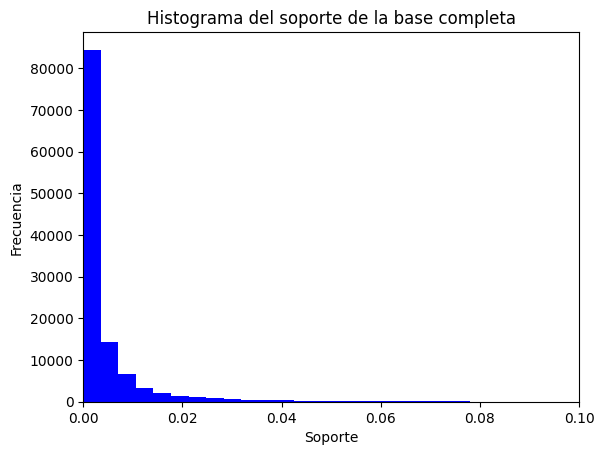

Intervalos: [0.0000e+00 5.0000e-04 8.7500e-04 1.5000e-03 2.8750e-03 6.8750e-03
 7.0875e-01]


In [81]:
soportes = [ i[2] for i in baseCompleta]
plt.hist(soportes, bins=200, color='blue')
plt.xlabel('Soporte')
plt.ylabel('Frecuencia')
plt.title('Histograma del soporte de la base completa')
plt.xlim(0, 0.1)
plt.show()

# Convertir a Serie
serie = pd.Series(soportes)

# Dividir en 4 grupos (cuartiles, puedes usar más)
grupos, bins = pd.qcut(serie, q=6, retbins=True, labels=False, duplicates='drop')

# Mostrar los límites de los intervalos
print("Intervalos:", bins)

In [73]:
print(len(baseCompleta))

117920


In [47]:
# Cargar el dataset de prueba
test_data = pd.read_csv('test_data_cm.csv').fillna('') # Rellenar valores nulos con cadena vacía
etiquetas = test_data['Exited']
datos = test_data.drop(columns=['Exited'])
print(f"Número de datos de prueba: {len(datos)}")

Número de datos de prueba: 2000


In [74]:
etiquetas.value_counts(normalize=True).map(lambda x: f"{x*100:.2f}%")


Exited
     79.65%
X    20.35%
Name: proportion, dtype: object

In [70]:
# Listas para almacenar los datos
resultados_csv = []
confianzas = [0, 0.2, 0.5, 0.8, 0.9, 0.95]
soportes = bins
#confianzas = [0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85]
#soportes = [4/712, 5/712, 6/712, 7/712, 8/712, 9/712, 10/712, 11/712, 12/712, 13/712]
for conf in confianzas:
    for sop in soportes:
        # and 'Exited' not in i[0][0] and 'Exited' in i[0][1]
        context.base_completa = [i for i in baseCompleta if i[1] >= conf and i[2] >= sop and 'Exited' not in i[0][0] and 'Exited' in i[0][1]]
        resultados = context.calcula_resultados(datos, etiquetas)

        antecedente = sum(1 for t in context.base_completa if "Exited" in t[0][0])
        consecuente = sum(1 for t in context.base_completa if "Exited" in t[0][1])

        resultados_csv.append({
            "Confianza": round(conf, 2),
            "Soporte": round(sop, 4),
            "R. acierto": round(resultados[0], 3),
            "FP": resultados[1],
            "FN": resultados[2],
            "Total": len(context.base_completa),
        })

# Crear DataFrame y guardar en CSV
df = pd.DataFrame(resultados_csv)
df.to_csv("resultados_CM_completa.csv", index=False)

# Mostrar tabla
print(df)

    Confianza  Soporte  R. acierto   FP   FN  Total
0        0.00   0.0000       0.788  247  176   2713
1        0.00   0.0005       0.819  169  193   1747
2        0.00   0.0009       0.826  144  203   1210
3        0.00   0.0015       0.828  127  218    733
4        0.00   0.0029       0.830  102  237    282
5        0.00   0.0069       0.826   79  270     42
6        0.00   0.7088       0.796    0  407      0
7        0.20   0.0000       0.788  247  176   2713
8        0.20   0.0005       0.819  169  193   1747
9        0.20   0.0009       0.826  144  203   1210
10       0.20   0.0015       0.828  127  218    733
11       0.20   0.0029       0.830  102  237    282
12       0.20   0.0069       0.826   79  270     42
13       0.20   0.7088       0.796    0  407      0
14       0.50   0.0000       0.788  247  176   2713
15       0.50   0.0005       0.819  169  193   1747
16       0.50   0.0009       0.826  144  203   1210
17       0.50   0.0015       0.828  127  218    733
18       0.5

El siguiente código se ha utilizado para calcular los resultados con menos de 10.000 objetos y hacer pruebas.

In [ ]:
for i in [2000]:
    train_data, test_data = train_test_split(data.iloc[:i], test_size=0.2, random_state=42, stratify=data.iloc[:i]['Exited'])

    # Guardar los datasets de entrenamiento y prueba en archivos CSV
    train_data.to_csv("train_data_cm_temporal.csv", index=False)
    test_data.to_csv("test_data_cm_temporal.csv", index=False)
    context2 = Context.fromfile('train_data_cm_temporal.csv', frmat='csv')
    etiquetas = test_data['Exited']
    datos = test_data.drop(columns=['Exited'])

    # Listas para almacenar los datos
    resultados_csv = []
    confianzas = [0, 0.2, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
    soportes = [0.0, 1/1600, 2/1600, 4/1600, 8/1600, 16/1600, 32/1600, 64/1600, 128/1600, 256/1600, 500/1600, 1000/1600]
    #confianzas = [0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85]
    #soportes = [4/712, 5/712, 6/712, 7/712, 8/712, 9/712, 10/712, 11/712, 12/712, 13/712]
    context2.calcular_base_stem()
    for conf in confianzas:
        for sop in soportes:
            context2.set_confianza(conf)
            context2.set_soporte(sop)
            context2.calcular_base_luxenburger()
            context2.calcular_base_completa()
            context2.base_completa = [i for i in context2.base_completa if i[2] >= sop and 'Exited' not in i[0][0] and 'Exited' in i[0][1]]
            resultados = context2.calcula_resultados(datos, etiquetas)

            antecedente = sum(1 for t in context2.base_completa if "Exited" in t[0][0])
            consecuente = sum(1 for t in context2.base_completa if "Exited" in t[0][1])

            resultados_csv.append({
                "Confianza": round(conf, 2),
                "Soporte": round(sop, 3),
                "R. acierto": round(resultados[0], 3),
                "FP": resultados[1],
                "FN": resultados[2],
                "Total": len(context2.base_completa),
            })

    # Crear DataFrame y guardar en CSV
    df = pd.DataFrame(resultados_csv)
    df.to_csv("resultados_CM_2000_sinFiltro.csv", index=False)

    # Mostrar tabla
    print(df)

Con el siguiente código se han calculado los resultados temporales de la tabla de número de objetos VS tiempo de ejecución del final de la sección 3.

In [9]:
resultados_csv = []
for i in [10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]:
    train_data, test_data = train_test_split(data.iloc[:i], test_size=0.2, random_state=42, stratify=data.iloc[:i]['Exited'])

    # Guardar los datasets de entrenamiento y prueba en archivos CSV
    train_data.to_csv("train_data_cm_temporal.csv", index=False)
    test_data.to_csv("test_data_cm_temporal.csv", index=False)
    context = Context.fromfile('train_data_cm_temporal.csv', frmat='csv')
    context.set_confianza(0.8)
    context.set_soporte(0.0224719)
    etiquetas = test_data['Exited']
    datos = test_data.drop(columns=['Exited'])

    # Listas para almacenar los datos
    
    start_time = time.time()

    context.calcular_base_stem()
    context.calcular_base_luxenburger()
    context.calcular_base_completa()
    resultados = context.calcula_resultados(datos, etiquetas)

    end_time = time.time()
    elapsed_time = end_time - start_time

    tot_conceptos = len(context.lattice)
    dic= {
        "Objetos": i,
        "Tiempo": elapsed_time,
        "Conceptos": tot_conceptos,
        "Implicaciones": len(context.base_completa),
        "Resultados": resultados,
    }
    resultados_csv.append(dic)
    print(dic)

    # Crear DataFrame y guardar en CSV
    df = pd.DataFrame(resultados_csv)
    df.to_csv("resultados_CM_tiempos.csv", index=False)

# Mostrar tabla
print(df)

{'Objetos': 10, 'Tiempo': 0.03388214111328125, 'Conceptos': 74, 'Implicaciones': 81, 'Resultados': (np.float64(0.5), np.int64(1), np.int64(0))}
{'Objetos': 15, 'Tiempo': 0.09017276763916016, 'Conceptos': 172, 'Implicaciones': 183, 'Resultados': (np.float64(0.3333333333333333), np.int64(2), np.int64(0))}
{'Objetos': 20, 'Tiempo': 0.1838693618774414, 'Conceptos': 267, 'Implicaciones': 260, 'Resultados': (np.float64(0.25), np.int64(3), np.int64(0))}
{'Objetos': 30, 'Tiempo': 0.35245370864868164, 'Conceptos': 586, 'Implicaciones': 573, 'Resultados': (np.float64(0.16666666666666666), np.int64(5), np.int64(0))}
{'Objetos': 50, 'Tiempo': 1.2179865837097168, 'Conceptos': 1367, 'Implicaciones': 1014, 'Resultados': (np.float64(0.2), np.int64(8), np.int64(0))}
{'Objetos': 100, 'Tiempo': 6.099836587905884, 'Conceptos': 3348, 'Implicaciones': 2245, 'Resultados': (np.float64(0.2), np.int64(16), np.int64(0))}
{'Objetos': 150, 'Tiempo': 14.901398420333862, 'Conceptos': 5559, 'Implicaciones': 3798, 'Re

Traceback (most recent call last):
  File "C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3670, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_10908\3914926091.py", line 18, in <module>
    context.calcular_base_stem()
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_10908\3131996546.py", line 75, in calcular_base_stem
    conj_atrib = self.next_closure(conj_atrib, base)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_10908\3131996546.py", line 55, in next_closure
    sig_conj_cerrado=self.cerrar(conjunto | {atributo}, conj_impls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_10908\3131996546.py", line None, in cerrar
KeyboardInterrupt

During handling of